<h1><center>Generative Adversarial Networks</center></h1>

Задача
1. Обучить генератор создавать точки, которые будут лежать на графике функции
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

from pylab import rcParams
rcParams['figure.figsize'] = 20,7

import math
from math import sin

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Определим нужное нам устройство:

### 1. Создание датасета

In [4]:
size = 2  # две координаты точки
batch_size = 16  # размер батча

x = np.linspace(-100, 100, 10000)
y_func = np.vectorize(lambda t: sin(t)/t - t/10)
y = y_func(x)


In [5]:
x

array([-100.      ,  -99.979998,  -99.959996, ...,   99.959996,
         99.979998,  100.      ])

In [6]:
y

array([  9.99493634,   9.99276364,   9.99059296, ..., -10.00140624,
       -10.00323596, -10.00506366])

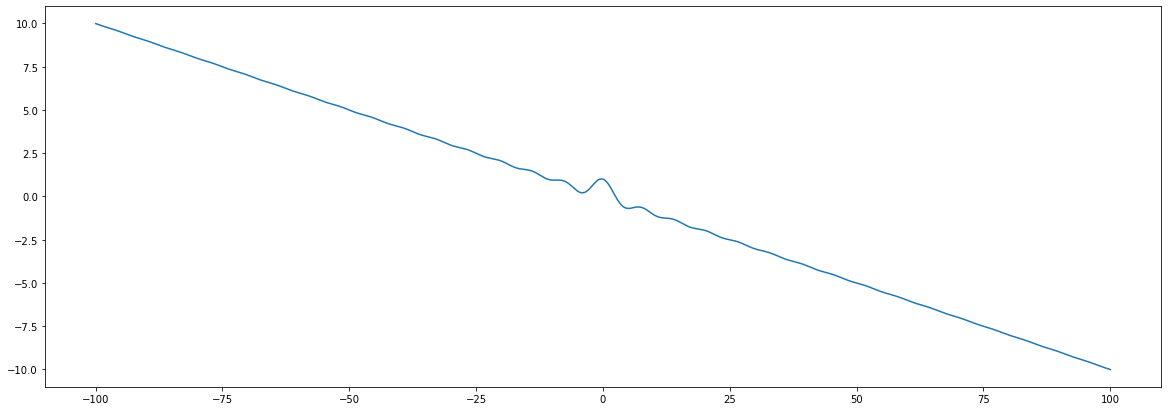

In [7]:
plt.plot(x, y)

In [8]:
df = np.hstack([x.reshape(10000,1), y.reshape(10000,1)])

In [9]:
df.shape

(10000, 2)

In [10]:
df

array([[-100.        ,    9.99493634],
       [ -99.979998  ,    9.99276364],
       [ -99.959996  ,    9.99059296],
       ...,
       [  99.959996  ,  -10.00140624],
       [  99.979998  ,  -10.00323596],
       [ 100.        ,  -10.00506366]])

In [11]:
class Point_dataset:
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = 1
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [12]:
point_df = Point_dataset(df)

In [13]:
real_data = torch.utils.data.DataLoader(point_df,
    batch_size=batch_size,
    shuffle=True,
)

### 2. Создание модели

#### 2.1 Генератор

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])

        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)] 
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        point = self.model(z)
        return point

In [15]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005)
        nn.init.uniform_(self.bias, -0.005, 0.005)

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

In [16]:
layer = CustomLinearLayer(1, 2)
layer.weights, layer.bias

(Parameter containing:
 tensor([[ 0.0041],
         [-0.0017]], requires_grad=True),
 Parameter containing:
 tensor([-0.0017, -0.0039], requires_grad=True))

#### 2.2 Дискриминатор

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )


    def forward(self, point):
        validity = self.model(point)
        return validity

# 3. Обучение

Инициализация:

In [18]:
n_epochs = 10  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения

In [19]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(),
    lr=lr,
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [20]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

[Epoch 9/10] [Batch 375/625]|[D loss: 0.6930668354034424] [G loss: 0.6944097876548767]


<Figure size 1440x504 with 0 Axes>

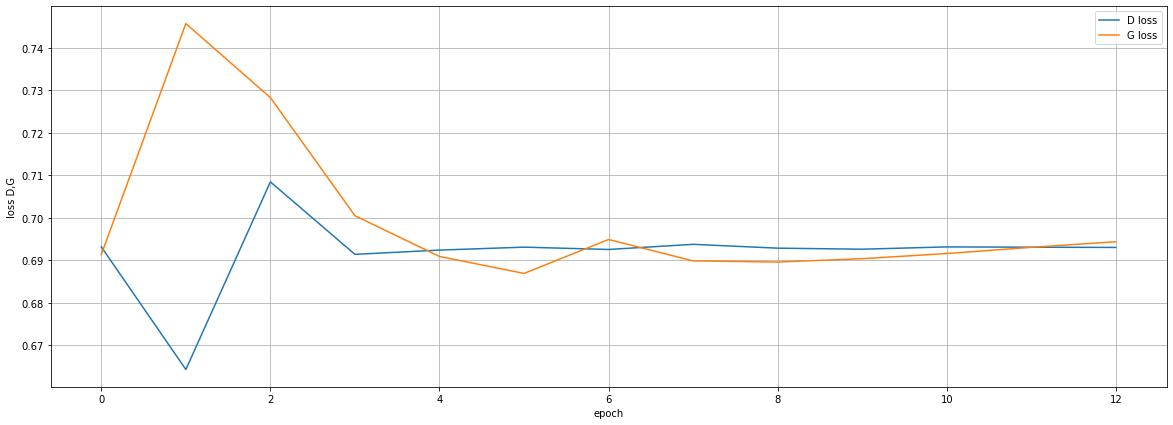

In [21]:
import matplotlib.patches as mpatches


for epoch in range(n_epochs):
    for i, (points, labels) in enumerate(real_data):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_points = points.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)

######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_points)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_points)

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################

        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_points)

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)

        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')


                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.grid()
                plt.xlabel('epoch')
                plt.ylabel('loss D,G')
                plt.show()

In [22]:
torch.save(generator.state_dict(), "graf_gan.pth")

In [23]:
generator = Generator().to(device)
generator.load_state_dict(torch.load("graf_gan.pth"))

<All keys matched successfully>

In [24]:
for param in list(generator.parameters())[:]:
    param.requires_grad = False

### Сгенерируем точки с помощью обученного генератора

In [25]:
gen_list = []
for i in range(10):
    z = torch.FloatTensor(np.random.normal(-100, 100, (batch_size, latent_dim))).to(device)
    gen_list.append(generator(z).numpy())

In [26]:
gen = gen_list[0]
for i in range(1, 10):
    gen = np.vstack([gen, gen_list[i]])
    
gen

array([[ 4.28356552e+01, -4.42861986e+00],
       [ 1.81973877e+01, -1.72130203e+00],
       [ 1.94670753e+01, -2.29428148e+00],
       [ 4.47884979e+01, -4.84665012e+00],
       [-6.36292725e+01,  5.92688084e+00],
       [ 4.82899323e+01, -4.93334770e+00],
       [-9.87413788e+01,  9.16037750e+00],
       [-2.64936562e+01,  1.23019350e+00],
       [-3.66714745e+01,  2.34171224e+00],
       [-8.47189236e+00,  9.50337499e-02],
       [ 4.82420464e+01, -5.21338034e+00],
       [ 6.03630371e+01, -6.28455162e+00],
       [-1.01131104e+02,  1.02770157e+01],
       [ 4.76515083e+01, -5.16831017e+00],
       [ 3.23488541e+01, -3.57803822e+00],
       [-5.32671051e+01,  4.31661415e+00],
       [ 5.30871811e+01, -5.55076170e+00],
       [-1.35270090e+01,  1.56485677e-01],
       [ 1.61436386e+01, -1.93471277e+00],
       [-3.18925514e+01,  2.35627890e+00],
       [ 4.83379593e+01, -5.01687622e+00],
       [ 3.93424530e+01, -4.08152342e+00],
       [ 4.27969933e+01, -4.34665298e+00],
       [ 5.

In [27]:
gen.shape

(160, 2)

In [28]:
gen[:,1]

array([-4.42862   , -1.721302  , -2.2942815 , -4.84665   ,  5.926881  ,
       -4.9333477 ,  9.1603775 ,  1.2301935 ,  2.3417122 ,  0.09503375,
       -5.2133803 , -6.2845516 , 10.277016  , -5.16831   , -3.5780382 ,
        4.316614  , -5.5507617 ,  0.15648568, -1.9347128 ,  2.356279  ,
       -5.016876  , -4.0815234 , -4.346653  , -6.042788  ,  1.3872104 ,
        7.3222265 , -7.918073  ,  7.4933777 ,  6.08558   ,  1.2957463 ,
        1.9832845 ,  6.006607  ,  7.842661  , -2.8000407 , -1.7735596 ,
        0.9688806 , -4.0718884 , -8.238042  ,  2.0380383 ,  9.745195  ,
       -1.5809615 ,  4.1546073 ,  0.23134708,  1.227621  , -7.1564302 ,
        3.5531807 , -6.7861204 , -0.09696555, -3.9132118 , -2.1976328 ,
       -3.9376254 , 11.693616  , -5.22057   , -3.2848382 , -0.20498058,
       -7.7483373 ,  5.4212255 ,  5.7351427 ,  2.5890923 , -5.164812  ,
       -1.9647092 ,  6.8127255 , -1.950408  ,  0.12198158, -4.6633644 ,
       -6.596897  ,  6.3981147 , -3.0783503 , -2.3335826 , -3.44

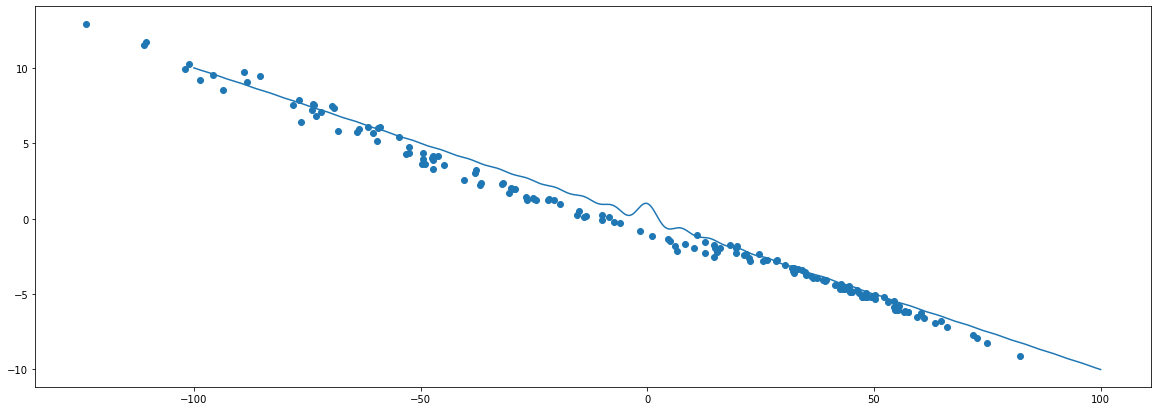

In [29]:
plt.plot(x, y) # ревльные данные
plt.scatter(gen[:,0], gen[:,1]) # сгенерированные точки

Видим, что генератор справляется с поставленной задачей неплохо с учетом 10000 экземпляров - учителей и 10 эпох обучения